# Homework 3 
Bruce Cai


In [1]:
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm
from ISLP import load_data,confusion_table
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.pyplot import subplots
from statsmodels.stats.anova import anova_lm
from ISLP.models import bs, ns
from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART
import sklearn.model_selection as skm
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay
roc_curve = RocCurveDisplay.from_estimator
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

## Chapter 8
3. Consider the Gini index, classifcation error, and entropy in a simple
classifcation setting with two classes. Create a single plot that displays each of these quantities as a function of pˆm1. The x-axis should
display pˆm1, ranging from 0 to 1, and the y-axis should display the
value of the Gini index, classifcation error, and entropy.
Hint: In a setting with two classes, pˆm1 = 1 − pˆm2. You could make
this plot by hand, but it will be much easier to make in R.

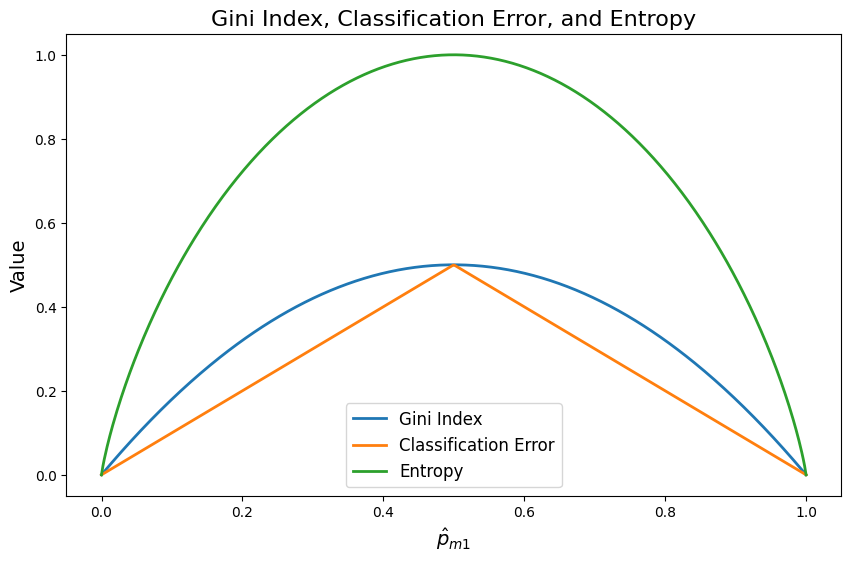

In [2]:
p_hat_m1 = np.linspace(0, 1, 500)


gini_index = 2 * p_hat_m1 * (1 - p_hat_m1)
classification_error = 1 - np.maximum(p_hat_m1, 1 - p_hat_m1)
entropy = -(p_hat_m1 * np.log2(p_hat_m1 + 1e-10) + (1 - p_hat_m1) * np.log2(1 - p_hat_m1 + 1e-10))

plt.figure(figsize=(10, 6))
plt.plot(p_hat_m1, gini_index, label="Gini Index", linewidth=2)
plt.plot(p_hat_m1, classification_error, label="Classification Error", linewidth=2)
plt.plot(p_hat_m1, entropy, label="Entropy", linewidth=2)
plt.xlabel(r"$\hat{p}_{m1}$", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.title("Gini Index, Classification Error, and Entropy", fontsize=16)
plt.legend(fontsize=12)
plt.show()

5. Suppose we produce ten bootstrapped samples from a data set
containing red and green classes. We then apply a classifcation tree
to each bootstrapped sample and, for a specifc value of X, produce
10 estimates of P(Class is Red|X):
0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, and 0.75.
There are two common ways to combine these results together into a
single class prediction. One is the majority vote approach discussed in
this chapter. The second approach is to classify based on the average
probability. In this example, what is the final classifcation under each
of these two approaches?

In [3]:
P = [0.1,0.15,0.2,0.2,0.55,0.6,0.6,0.65,0.7,0.75]
#Majority Vote Approach
P_red = len([i for i in P if i>0.5])
P_green = len([i for i in P if i<=0.5])
if P_red > len(P)/2:
    print('Majority Vote: Red')
elif P_green > len(P)/2:
    print('Majority Vote: Green')
else:
    print('Majority Vote: Equal')
#Average Probability Approach
P_avg = np.mean(P)
if P_avg > 0.5:
    print('Average Probability: Red')
else:
    print('Average Probability: Green')


Majority Vote: Red
Average Probability: Green


12. Apply boosting, bagging, random forests, and BART to a data set
of your choice. Be sure to ft the models on a training set and to
evaluate their performance on a test set. How accurate are the results
compared to simple methods like linear or logistic regression? Which
of these approaches yields the best performance?


In [4]:
data = load_data('College')
data.head(5)

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [5]:
X = data.drop(columns=['Grad.Rate','Private']) 
y = data['Grad.Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

boosting = GradientBoostingRegressor(random_state=42)
bagging = BaggingRegressor(random_state=42)
random_forest = RandomForestRegressor(random_state=42)
linear = LinearRegression()

#Train models
boosting.fit(X_train, y_train)
bagging.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
linear.fit(X_train, y_train)

#predictions
boosting_pred = boosting.predict(X_test)
bagging_pred = bagging.predict(X_test)
random_forest_pred = random_forest.predict(X_test)
linear_pred = linear.predict(X_test)

#Evaluate models
boosting_mse = mean_squared_error(y_test, boosting_pred)
bagging_mse = mean_squared_error(y_test, bagging_pred)
random_forest_mse = mean_squared_error(y_test, random_forest_pred)
linear_mse = mean_squared_error(y_test, linear_pred)

results = pd.DataFrame({
    "Model": ["Boosting", "Bagging", "Random Forest","Linear Regression"],
    "MSE": [boosting_mse, bagging_mse, random_forest_mse, linear_mse]
})
results



,Model,MSE
0,Boosting,118.106150
1,Bagging,131.879167
2,Random Forest,109.333386
3,Linear Regression,117.671172


Random forests gave the best results with the default model, and both boosting and bagging had higher MSE than the linear model.

## Chapter 9
1. This problem involves hyperplanes in two dimensions.

(a) Sketch the hyperplane 1+3X1 − X2 = 0. Indicate the set of
points for which 1+3X1 − X2 > 0, as well as the set of points
for which 1+3X1 − X2 < 0.

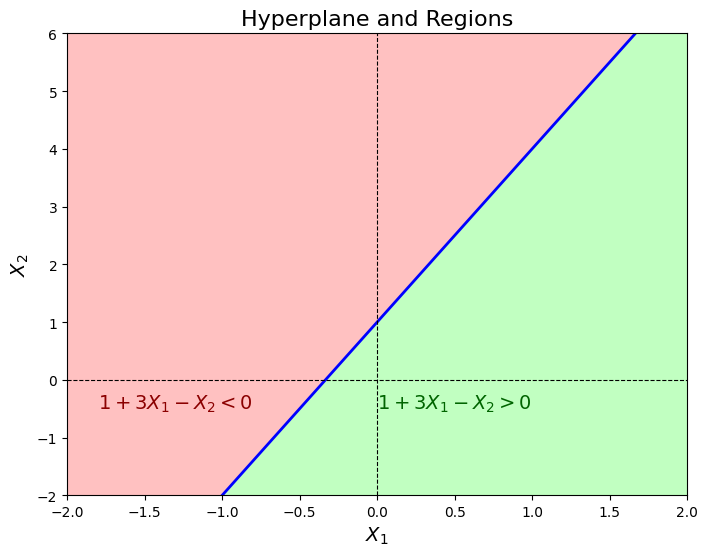

In [6]:
X1 = np.linspace(-2, 2, 400)  
X2 = 1 + 3 * X1  


X1_grid, X2_grid = np.meshgrid(np.linspace(-2, 2, 400), np.linspace(-2, 6, 400))
Z = 1 + 3 * X1_grid - X2_grid 

plt.figure(figsize=(8, 6))


plt.contourf(X1_grid, X2_grid, Z, levels=[-np.inf, 0, np.inf], colors=['#FF9999', '#99FF99'], alpha=0.6)


plt.plot(X1, X2, color='blue', linewidth=2)


plt.text(0, -0.5, r"$1 + 3X_1 - X_2 > 0$", fontsize=14, color="darkgreen")
plt.text(-1.8, -0.5, r"$1 + 3X_1 - X_2 < 0$", fontsize=14, color="darkred")


plt.xlim(-2, 2)
plt.ylim(-2, 6)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.xlabel(r"$X_1$", fontsize=14)
plt.ylabel(r"$X_2$", fontsize=14)
plt.title("Hyperplane and Regions", fontsize=16)


plt.show()

(b) On the same plot, sketch the hyperplane −2 + X1 + 2X2 = 0.
Indicate the set of points for which −2 + X1 + 2X2 > 0, as well
as the set of points for which −2 + X1 + 2X2 < 0.

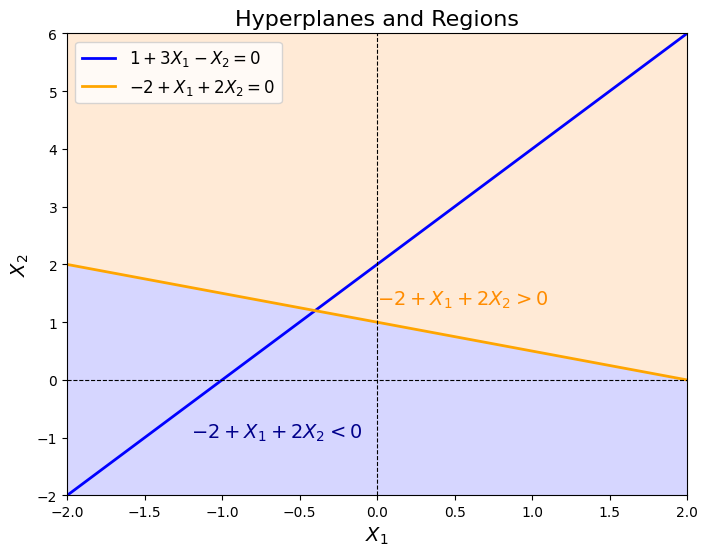

In [7]:
X2 = np.linspace(-2, 6, 400)  # Range of X2 values
X1_hyper2 = 2 - 2 * X2  # Calculate X1 using -2 + X1 + 2X2 = 0

# Evaluate the second hyperplane equation on the grid
Z_hyper2 = -2 + X1_grid + 2 * X2_grid

# Plot the regions and hyperplanes
plt.figure(figsize=(8, 6))

# Shaded regions for the first hyperplane


# Shaded regions for the second hyperplane
plt.contourf(X1_grid, X2_grid, Z_hyper2, levels=[-np.inf, 0, np.inf], colors=['#9999FF', '#FFCC99'], alpha=0.4)

# Plot the hyperplanes
plt.plot(X1, X2, color='blue', linewidth=2, label=r"$1 + 3X_1 - X_2 = 0$")
plt.plot(X1_hyper2, X2, color='orange', linewidth=2, label=r"$-2 + X_1 + 2X_2 = 0$")

# Add annotations for the second hyperplane
plt.text(0, 1.3, r"$-2 + X_1 + 2X_2 > 0$", fontsize=14, color="darkorange")
plt.text(-1.2, -1, r"$-2 + X_1 + 2X_2 < 0$", fontsize=14, color="darkblue")

# Set plot limits and labels
plt.xlim(-2, 2)
plt.ylim(-2, 6)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.xlabel(r"$X_1$", fontsize=14)
plt.ylabel(r"$X_2$", fontsize=14)
plt.title("Hyperplanes and Regions", fontsize=16)
plt.legend(fontsize=12, loc='upper left')
plt.show()

5. We have seen that we can ft an SVM with a non-linear kernel in order
to perform classifcation using a non-linear decision boundary. We will
now see that we can also obtain a non-linear decision boundary by
performing logistic regression using non-linear transformations of the
features.

(a) Generate a data set with n = 500 and p = 2, such that the observations belong to two classes with a quadratic decision boundary
between them. For instance, you can do this as follows:

rng = np.random.default_rng(5)

x1 = rng.uniform(size=500) - 0.5

x2 = rng.uniform(size=500) - 0.5

y = x1**2 - x2**2 > 0

In [8]:
rng = np.random.default_rng(5)
x1 = rng.uniform(size=500) - 0.5
x2 = rng.uniform(size=500) - 0.5
y = x1**2 - x2**2 > 0

(b) Plot the observations, colored according to their class labels.
Your plot should display X1 on the x-axis, and X2 on the y-axis

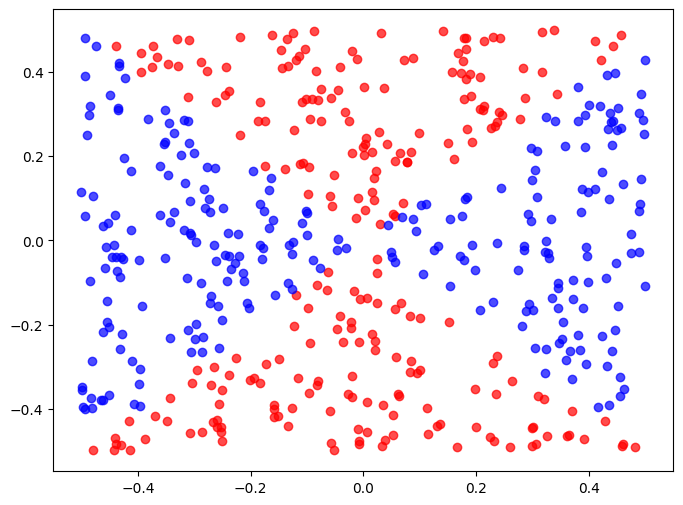

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(x1[y == 0], x2[y == 0], color='red', alpha=0.7, label="Class 0")
plt.scatter(x1[y == 1], x2[y == 1], color='blue', alpha=0.7, label="Class 1")

(c) Fit a logistic regression model to the data, using X1 and X2 as
predictors.

In [10]:
X = np.column_stack((x1, x2)) 

logistic_model = LogisticRegression()
logistic_model.fit(X, y)
coefficients = logistic_model.coef_
intercept = logistic_model.intercept_

coefficients, intercept


(array([[-0.15143042,  0.08184281]]), array([0.02220278]))

(d) Apply this model to the training data in order to obtain a predicted class label for each training observation. Plot the observations, colored according to the predicted class labels. The
decision boundary should be linear.

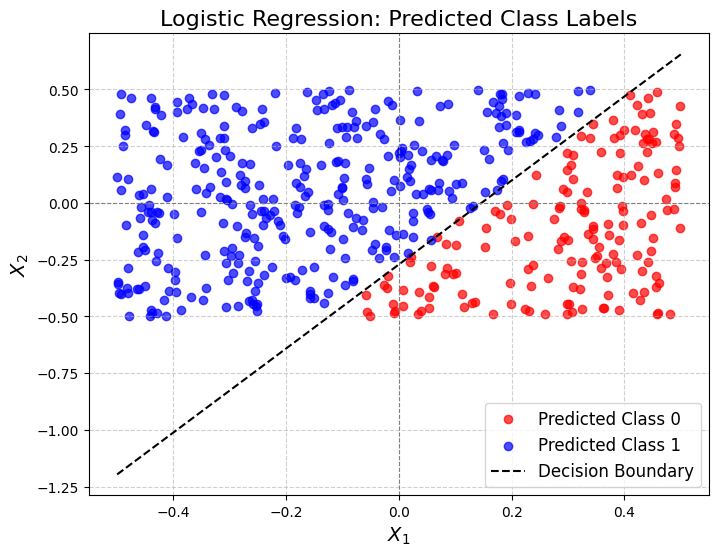

In [11]:
y_pred = logistic_model.predict(X)


plt.figure(figsize=(8, 6))
plt.scatter(x1[y_pred == 0], x2[y_pred == 0], color='red', alpha=0.7, label="Predicted Class 0")
plt.scatter(x1[y_pred == 1], x2[y_pred == 1], color='blue', alpha=0.7, label="Predicted Class 1")


x_boundary = np.linspace(-0.5, 0.5, 500)
y_boundary = -(logistic_model.coef_[0][0] * x_boundary + logistic_model.intercept_[0]) / logistic_model.coef_[0][1]

plt.plot(x_boundary, y_boundary, color='black', linestyle='--', linewidth=1.5, label="Decision Boundary")


plt.xlabel("$X_1$", fontsize=14)
plt.ylabel("$X_2$", fontsize=14)
plt.title("Logistic Regression: Predicted Class Labels", fontsize=16)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

(e) Now ft a logistic regression model to the data using non-linear
functions of X1 and X2 as predictors (e.g. X2
1 , X1×X2, log(X2),
and so forth).

In [12]:
X_non_linear = np.column_stack((x1, x2, x1**2, x2**2, x1 * x2))

logistic_model_non_linear = LogisticRegression()
logistic_model_non_linear.fit(X_non_linear, y)



LogisticRegression()

(f) Apply this model to the training data in order to obtain a predicted class label for each training observation. Plot the observations, colored according to the predicted class labels. The
decision boundary should be obviously non-linear. If it is not,
then repeat (a)–(e) until you come up with an example in which
the predicted class labels are obviously non-linear.

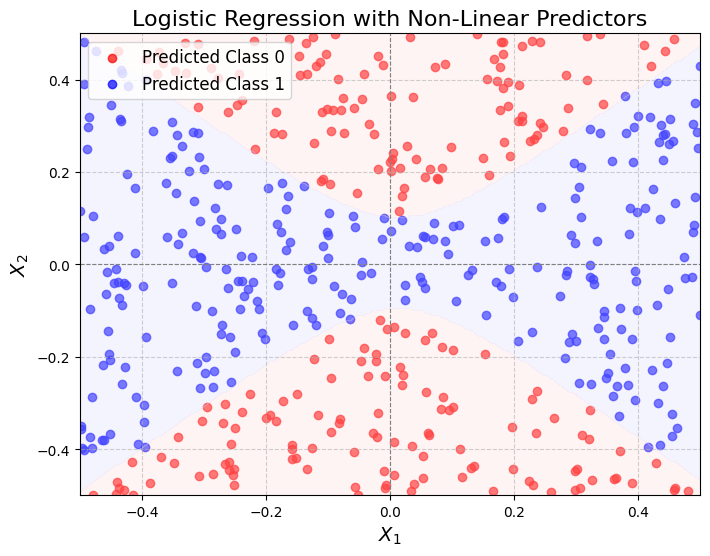

In [13]:
y_pred_non_linear = logistic_model_non_linear.predict(X_non_linear)


plt.figure(figsize=(8, 6))
plt.scatter(x1[y_pred_non_linear == 0], x2[y_pred_non_linear == 0], color='red', alpha=0.7, label="Predicted Class 0")
plt.scatter(x1[y_pred_non_linear == 1], x2[y_pred_non_linear == 1], color='blue', alpha=0.7, label="Predicted Class 1")


x1_grid, x2_grid = np.meshgrid(np.linspace(-0.5, 0.5, 200), np.linspace(-0.5, 0.5, 200))
X_grid = np.column_stack((
    x1_grid.ravel(), 
    x2_grid.ravel(), 
    x1_grid.ravel()**2, 
    x2_grid.ravel()**2, 
    
    np.log(np.abs(x2_grid.ravel()) + 1)
))
z = logistic_model_non_linear.predict(X_grid).reshape(x1_grid.shape)
plt.contourf(x1_grid, x2_grid, z, levels=[-0.5, 0.5, 1.5], colors=['#FFDDDD', '#DDDDFF'], alpha=0.3)


plt.xlabel("$X_1$", fontsize=14)
plt.ylabel("$X_2$", fontsize=14)
plt.title("Logistic Regression with Non-Linear Predictors", fontsize=16)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

(g) Fit a support vector classifer to the data with X1 and X2 as
predictors. Obtain a class prediction for each training observation. Plot the observations, colored according to the predicted
class labels.

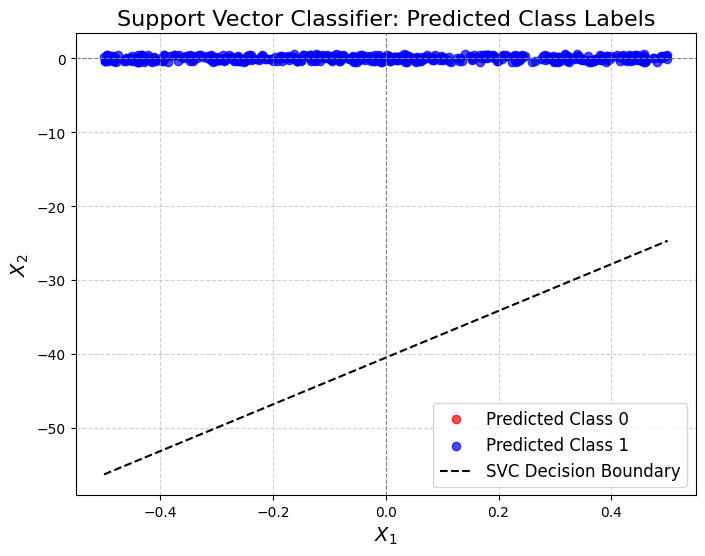

In [14]:
svc = SVC(kernel='linear', random_state=42)
svc.fit(X, y)

y_pred_svc = svc.predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(x1[y_pred_svc == 0], x2[y_pred_svc == 0], color='red', alpha=0.7, label="Predicted Class 0")
plt.scatter(x1[y_pred_svc == 1], x2[y_pred_svc == 1], color='blue', alpha=0.7, label="Predicted Class 1")


coef = svc.coef_[0]
intercept = svc.intercept_[0]
x_boundary = np.linspace(-0.5, 0.5, 500)
y_boundary = -(coef[0] * x_boundary + intercept) / coef[1]

plt.plot(x_boundary, y_boundary, color='black', linestyle='--', linewidth=1.5, label="SVC Decision Boundary")

plt.xlabel("$X_1$", fontsize=14)
plt.ylabel("$X_2$", fontsize=14)
plt.title("Support Vector Classifier: Predicted Class Labels", fontsize=16)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

(h) Fit a SVM using a non-linear kernel to the data. Obtain a class
prediction for each training observation. Plot the observations,
colored according to the predicted class labels.

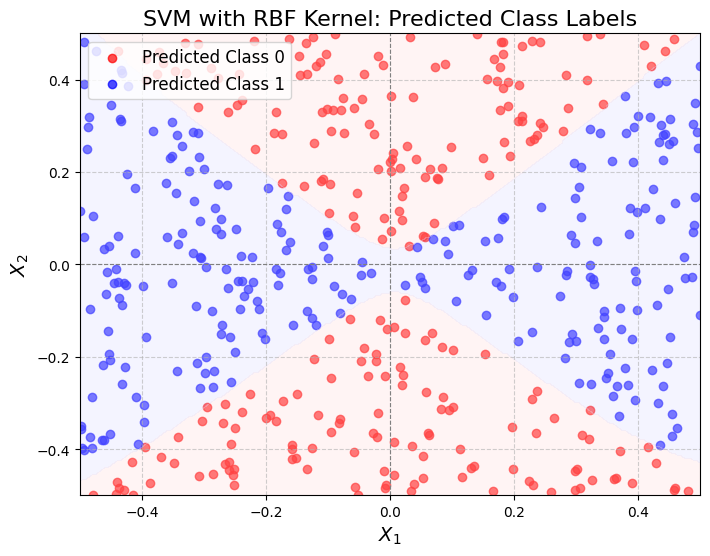

In [15]:
svc_rbf = SVC(kernel='rbf', random_state=42, gamma='scale', C=1.0)
svc_rbf.fit(X, y)

y_pred_svc_rbf = svc_rbf.predict(X)


plt.figure(figsize=(8, 6))
plt.scatter(x1[y_pred_svc_rbf == 0], x2[y_pred_svc_rbf == 0], color='red', alpha=0.7, label="Predicted Class 0")
plt.scatter(x1[y_pred_svc_rbf == 1], x2[y_pred_svc_rbf == 1], color='blue', alpha=0.7, label="Predicted Class 1")


x1_grid, x2_grid = np.meshgrid(np.linspace(-0.5, 0.5, 200), np.linspace(-0.5, 0.5, 200))
z_rbf = svc_rbf.decision_function(np.column_stack((x1_grid.ravel(), x2_grid.ravel()))).reshape(x1_grid.shape)
plt.contourf(x1_grid, x2_grid, z_rbf > 0, levels=[-1, 0, 1], colors=['#FFDDDD', '#DDDDFF'], alpha=0.3)


plt.xlabel("$X_1$", fontsize=14)
plt.ylabel("$X_2$", fontsize=14)
plt.title("SVM with RBF Kernel: Predicted Class Labels", fontsize=16)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

(i) Comment on your results.

Logistic Regression and Linear SVM: These models failed to accurately classify the observations in regions where the true decision boundary is curved. The linear decision boundary generated by logistic regression and linear SVM is overly simplistic for the quadratic relationship in the data.

Non-linear Logistic Regression: By introducing non-linear transformations, the logistic regression model porformed much better on capturing the quadratic structure.

The SVM with an RBF kernel demonstrated strong performance, capturing the complex quadratic decision boundary in the data.


8. This problem involves the OJ data set which is part of the ISLP
package.

(a) Create a training set containing a random sample of 800
observations, and a test set containing the remaining
observations.

In [16]:
data = load_data('OJ')

data['Store7'] = data['Store7'].map({'Yes': 1, 'No': 0})
data.head(5)

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,1,0.000000,0.000000,0.00,0


In [17]:
train_data, test_data = train_test_split(data, train_size=800, random_state=42)

(b) Fit a support vector classifer to the training data using
C = 0.01, with Purchase as the response and the other variables
as predictors. How many support points are there?

In [18]:
X_train = train_data.drop(columns=['Purchase'])
y_train = train_data['Purchase']


svc = SVC(C=0.01, kernel='linear', random_state=42)
svc.fit(X_train, y_train)


num_support_vectors = len(svc.support_)

num_support_vectors


615

(c) What are the training and test error rates?

In [19]:
X_test = test_data.drop(columns=['Purchase'])
y_test = test_data['Purchase']

# Predict on training and test sets
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

# Calculate error rates
train_error_rate = 1 - accuracy_score(y_train, y_train_pred)
test_error_rate = 1 - accuracy_score(y_test, y_test_pred)

train_error_rate, test_error_rate

(0.24, 0.2777777777777778)

(d) Use cross-validation to select an optimal C. Consider values in
the range 0.01 to 10.

In [ ]:
C_values = [0.01,0.1,1, 3,5,8,10]
cv_errors = []

for C in C_values:
    svm_model = SVC(C=C, kernel='linear')
    scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='accuracy')
    cv_error = 1 - scores.mean()  # Convert accuracy to error rate
    cv_errors.append(cv_error)
    print(f"C={C}: Cross-Validation Error = {cv_error:.4f}")
# param_grid = {'C': [0.01,0.1,1, 3,5,8,10]}  # C values from 0.01 to 10, log spaced
# svc = SVC(kernel='linear', random_state=42)
# grid_search = GridSearchCV(svc, param_grid, cv=kfold, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Extract the best C and corresponding results
# best_C = grid_search.best_params_['C']
# best_score = grid_search.best_score_

# best_C, best_score

C=0.01: Cross-Validation Error = 0.3087
C=0.1: Cross-Validation Error = 0.1763
C=1: Cross-Validation Error = 0.1650
C=3: Cross-Validation Error = 0.1675


Optimal C is 1. My code doesn't respond when C is greater than 3, it keeps running.

(e) Compute the training and test error rates using this new value
for C.

In [21]:
svc_new = SVC(C=1, kernel='linear',random_state=42)
svc_new.fit(X_train, y_train)


# Predict on training and test sets
y_train_pred = svc_new.predict(X_train)
y_test_pred = svc_new.predict(X_test)

# Calculate error rates
train_error_rate = 1 - accuracy_score(y_train, y_train_pred)
test_error_rate = 1 - accuracy_score(y_test, y_test_pred)

train_error_rate, test_error_rate

(0.15375000000000005, 0.19259259259259254)

(f) Repeat parts (b) through (e) using a support vector machine
with a radial kernel. Use the default value for gamma.

In [ ]:
svc_rbf_initial = SVC(C=0.01, kernel='rbf', random_state=42)
svc_rbf_initial.fit(X_train, y_train)
param_grid = {'C': np.logspace(-2, 1, 20)}
# Predict on training and test sets with the radial kernel SVM (C=0.01)
y_train_pred_rbf_initial = svc_rbf_initial.predict(X_train)
y_test_pred_rbf_initial = svc_rbf_initial.predict(X_test)

# Calculate initial error rates for the radial kernel SVM (C=0.01)
train_error_rate_rbf_initial = 1 - accuracy_score(y_train, y_train_pred_rbf_initial)
test_error_rate_rbf_initial = 1 - accuracy_score(y_test, y_test_pred_rbf_initial)

# Perform cross-validation to select the optimal C for the radial kernel
svc_rbf_cv = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid, cv=5, scoring='accuracy')
svc_rbf_cv.fit(X_train, y_train)

# Get the best C value for the radial kernel
best_C_rbf = svc_rbf_cv.best_params_['C']

# Refit the radial kernel SVM using the optimal C value
svc_rbf_optimized = SVC(C=best_C_rbf, kernel='rbf', random_state=42)
svc_rbf_optimized.fit(X_train, y_train)

# Predict on training and test sets with the optimized radial kernel SVM
y_train_pred_rbf_optimized = svc_rbf_optimized.predict(X_train)
y_test_pred_rbf_optimized = svc_rbf_optimized.predict(X_test)

# Calculate error rates for the optimized radial kernel SVM
train_error_rate_rbf_optimized = 1 - accuracy_score(y_train, y_train_pred_rbf_optimized)
test_error_rate_rbf_optimized = 1 - accuracy_score(y_test, y_test_pred_rbf_optimized)
{
    "Initial Train Error Rate (C=0.01)": train_error_rate_rbf_initial,
    "Initial Test Error Rate (C=0.01)": test_error_rate_rbf_initial,
    "Optimal C for RBF": best_C_rbf,
    "Optimized Train Error Rate": train_error_rate_rbf_optimized,
    "Optimized Test Error Rate": test_error_rate_rbf_optimized,
}

{'Initial Train Error Rate (C=0.01)': 0.38249999999999995,
 'Initial Test Error Rate (C=0.01)': 0.4111111111111111,
 'Optimal C for RBF': 0.01,
 'Optimized Train Error Rate': 0.38249999999999995,
 'Optimized Test Error Rate': 0.4111111111111111}

(g) Repeat parts (b) through (e) using a support vector machine
with a polynomial kernel. Set degree = 2.

(g) Repeat parts (b) through (e) using a support vector machine
with a polynomial kernel. Set degree = 2.

In [24]:
svc_poly_initial = SVC(C=0.01, kernel='poly', degree=2, random_state=42)
svc_poly_initial.fit(X_train, y_train)
param_grid = {'C': np.logspace(-2, 1, 20)}
# Predict on training and test sets with the polynomial kernel SVM (C=0.01)
y_train_pred_poly_initial = svc_poly_initial.predict(X_train)
y_test_pred_poly_initial = svc_poly_initial.predict(X_test)

# Calculate initial error rates for the polynomial kernel SVM (C=0.01)
train_error_rate_poly_initial = 1 - accuracy_score(y_train, y_train_pred_poly_initial)
test_error_rate_poly_initial = 1 - accuracy_score(y_test, y_test_pred_poly_initial)

# Perform cross-validation to select the optimal C for the polynomial kernel
svc_poly_cv = GridSearchCV(SVC(kernel='poly', degree=2, random_state=42), param_grid, cv=5, scoring='accuracy')
svc_poly_cv.fit(X_train, y_train)

# Get the best C value for the polynomial kernel
best_C_poly = svc_poly_cv.best_params_['C']

# Refit the polynomial kernel SVM using the optimal C value
svc_poly_optimized = SVC(C=best_C_poly, kernel='poly', degree=2, random_state=42)
svc_poly_optimized.fit(X_train, y_train)

# Predict on training and test sets with the optimized polynomial kernel SVM
y_train_pred_poly_optimized = svc_poly_optimized.predict(X_train)
y_test_pred_poly_optimized = svc_poly_optimized.predict(X_test)

# Calculate error rates for the optimized polynomial kernel SVM
train_error_rate_poly_optimized = 1 - accuracy_score(y_train, y_train_pred_poly_optimized)
test_error_rate_poly_optimized = 1 - accuracy_score(y_test, y_test_pred_poly_optimized)

{
    "Initial Train Error Rate (C=0.01)": train_error_rate_poly_initial,
    "Initial Test Error Rate (C=0.01)": test_error_rate_poly_initial,
    "Optimal C for RBF": best_C_poly,
    "Optimized Train Error Rate": train_error_rate_poly_optimized,
    "Optimized Test Error Rate": test_error_rate_poly_optimized,
}


{'Initial Train Error Rate (C=0.01)': 0.38249999999999995,
 'Initial Test Error Rate (C=0.01)': 0.4111111111111111,
 'Optimal C for RBF': 0.01,
 'Optimized Train Error Rate': 0.38249999999999995,
 'Optimized Test Error Rate': 0.4111111111111111}

(h) Overall, which approach seems to give the best results on this
data?

The optimal linear SCV (C=1) gives the best train result and best test result.